In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import yfinance as yf
from talib import abstract

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

/opt/anaconda3/lib/python3.7/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [10]:
# directly import strategies
SMA = abstract.SMA
EMA = abstract.EMA
MACD = abstract.MACD
RSI = abstract.RSI
STOCH = abstract.STOCH
STOCHRSI = abstract.STOCHRSI

## Getting Data from Yahoo Example
Additional info: https://pypi.org/project/yfinance/

In [3]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
# S&P500 index: ^GSPC
stock = yf.Ticker("^GSPC")

# one way to get data for period of interest
df = stock.history(period="3y")
df

# Other potential fields of interest
# stock.info
# stock.major_holders
# stock.recommendations
# stock.options

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-02-13,2646.270020,2668.840088,2637.080078,2662.939941,3472870000,0,0
2018-02-14,2651.209961,2702.100098,2648.870117,2698.629883,4003740000,0,0
2018-02-15,2713.459961,2731.510010,2689.820068,2731.199951,3684910000,0,0
2018-02-16,2727.139893,2754.419922,2725.110107,2732.219971,3637460000,0,0
2018-02-20,2722.989990,2737.600098,2706.760010,2716.260010,3627610000,0,0
...,...,...,...,...,...,...,...
2021-02-08,3892.590088,3915.770020,3892.590088,3915.590088,4635030000,0,0
2021-02-09,3910.489990,3918.350098,3902.639893,3911.229980,4554610000,0,0
2021-02-10,3920.780029,3931.500000,3884.939941,3909.879883,4815380000,0,0


## EDA

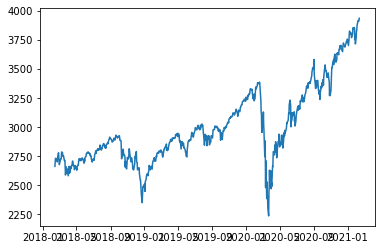

In [4]:
# Simple stock chart based on API data
plt.plot(df.Close)

### Adding Return Data

In [5]:
# Daily return based on Close price
df["Return"] = df["Close"] - df["Close"].shift(1)
df["Return%"] = df["Return"] / df["Close"]

# Next 5 day return based on Close price
df["N5D_Return"] = (df["Close"] - df["Close"].shift(-5)) * -1
df["N5D_Return%"] = df["N5D_Return"] / df["Close"]

df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,N5D_Return,N5D_Return%
Date,,,,,,,,,,,
2018-02-13,2646.270020,2668.840088,2637.080078,2662.939941,3472870000,0,0,NaN,NaN,38.390137,0.014416
2018-02-14,2651.209961,2702.100098,2648.870117,2698.629883,4003740000,0,0,35.689941,0.013225,5.330078,0.001975
2018-02-15,2713.459961,2731.510010,2689.820068,2731.199951,3684910000,0,0,32.570068,0.011925,16.100098,0.005895
2018-02-16,2727.139893,2754.419922,2725.110107,2732.219971,3637460000,0,0,1.020020,0.000373,47.380127,0.017341
2018-02-20,2722.989990,2737.600098,2706.760010,2716.260010,3627610000,0,0,-15.959961,-0.005876,28.020020,0.010316
2018-02-21,2720.530029,2747.750000,2701.290039,2701.330078,3779400000,0,0,-14.929932,-0.005527,12.500000,0.004627
2018-02-22,2710.419922,2731.260010,2697.770020,2703.959961,3701270000,0,0,2.629883,0.000973,-26.290039,-0.009723
2018-02-23,2715.800049,2747.760010,2713.739990,2747.300049,3189190000,0,0,43.340088,0.015776,-56.050049,-0.020402
2018-02-26,2757.370117,2780.639893,2753.780029,2779.600098,3424650000,0,0,32.300049,0.011620,-58.660156,-0.021104


### Adding Common Technical Levels/Signals to the Data

In [6]:
# Add simple moving averages (SMAs)
df["SMA3"] = SMA(df.Close, 3)
df["SMA5"] = SMA(df.Close, 5)
df["SMA10"] = SMA(df.Close, 10)
df["SMA15"] = SMA(df.Close, 15)
df["SMA20"] = SMA(df.Close, 20)
df["SMA30"] = SMA(df.Close, 30)
df["SMA50"] = SMA(df.Close, 50)

# Add exponential moving averages (EMAs)
# More info: https://www.investopedia.com/terms/e/ema.asp
df["EMA3"] = EMA(df.Close, 3)
df["EMA5"] = EMA(df.Close, 5)
df["EMA10"] = EMA(df.Close, 10)
df["EMA15"] = EMA(df.Close, 15)
df["EMA20"] = EMA(df.Close, 20)
df["EMA30"] = EMA(df.Close, 30)
df["EMA50"] = EMA(df.Close, 50)

# Add pivot point (PP) and classical support and resistance pivot points
# More info: https://www.investopedia.com/terms/p/pivotpoint.asp
df["PP"] = (df.High + df.Low + df.Close) / 3
df["S1C"] = df.PP * 2 - df.High
df["S2C"] = df.PP - (df.High - df.Low)
df["S3C"] = df.Low - 2 * (df.High - df.PP)
df["R1C"] = df.PP * 2 - df.Low 
df["R2C"] = df.PP + (df.High - df.Low)
df["R3C"] = df.High + 2 * (df.PP - df.Low)

# Add Fibonacci support and resistance pivot points
# More info: https://www.interactivebrokers.com/en/software/tws/usersguidebook/technicalanalytics/fibonaccipivotpoints.htm
df["S1F"] = df.PP - 0.382 * (df.High - df.Low)
df["S2F"] = df.PP - 0.618 * (df.High - df.Low)
df["S3F"] = df.PP - 1.0 * (df.High - df.Low)
df["R1F"] = df.PP + 0.382 * (df.High - df.Low)
df["R2F"] = df.PP + 0.618 * (df.High - df.Low)
df["R3F"] = df.PP + 1.0 * (df.High - df.Low)

df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,N5D_Return,...,S3C,R1C,R2C,R3C,S1F,S2F,S3F,R1F,R2F,R3F
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-13,2646.270020,2668.840088,2637.080078,2662.939941,3472870000,0,0,NaN,NaN,38.390137,...,2611.973307,2675.493327,2688.046712,2707.253337,2644.154379,2636.659016,2624.526693,2668.419026,2675.914389,2688.046712
2018-02-14,2651.209961,2702.100098,2648.870117,2698.629883,4003740000,0,0,35.689941,0.013225,5.330078,...,2611.069987,2717.529948,2736.430013,2770.759928,2662.866180,2650.303905,2629.970052,2703.533885,2716.096160,2736.430013
2018-02-15,2713.459961,2731.510010,2689.820068,2731.199951,3684910000,0,0,32.570068,0.011925,16.100098,...,2661.820068,2745.199951,2759.199951,2786.889893,2701.584452,2691.745626,2675.820068,2733.435567,2743.274394,2759.199951
2018-02-16,2727.139893,2754.419922,2725.110107,2732.219971,3637460000,0,0,1.020020,0.000373,47.380127,...,2690.770264,2749.389893,2766.559814,2778.699707,2726.053651,2719.136535,2707.940186,2748.446349,2755.363465,2766.559814
2018-02-20,2722.989990,2737.600098,2706.760010,2716.260010,3627610000,0,0,-15.959961,-0.005876,28.020020,...,2671.973226,2733.653402,2751.046794,2764.493490,2708.425792,2701.147531,2689.366618,2731.987619,2739.265880,2751.046794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,3892.590088,3915.770020,3892.590088,3915.590088,4635030000,0,0,28.760010,0.007345,NaN,...,3877.016846,3923.376709,3931.163330,3946.556641,3899.128665,3893.658201,3884.803467,3916.838132,3922.308596,3931.163330
2021-02-09,3910.489990,3918.350098,3902.639893,3911.229980,4554610000,0,0,-4.360107,-0.001115,NaN,...,3887.419678,3918.840088,3926.450195,3934.550293,3904.738692,3901.031083,3895.029785,3916.741289,3920.448897,3926.450195
2021-02-10,3920.780029,3931.500000,3884.939941,3909.879883,4815380000,0,0,-1.350098,-0.000345,NaN,...,3839.486491,3932.606608,3955.333333,3979.166667,3890.987332,3879.999159,3862.213216,3926.559217,3937.547391,3955.333333


### Adding Other Trading Signals to the Data

In [7]:
# Add SMA Crossing Signal
sma_fast = SMA(df.Close, 3)
sma_slow = SMA(df.Close, 15)
sma_signal = pd.Series(sma_fast > sma_slow).astype(int).diff().fillna(0)
df["SMA_Signal"] = sma_signal.values

# Add MACD Signal
macd, macdsignal, macdhist = MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)
macd_signal = pd.Series(macd > macdsignal).astype(int).diff().fillna(0)
df["MACD_Signal"] = macd_signal.values

# Add RSI Level and Signal
real = RSI(df.Close, timeperiod=14)
df["RSI"] = real
overbought = 70
oversold = 30
buy_signal = pd.Series(real <= oversold).astype(int)
sell_signal = pd.Series(real >= overbought).astype(int) * -1
rsi_signal = buy_signal + sell_signal
df["RSI_Signal"] = rsi_signal.values

# Add Stochastic Oscillator levels
slowk, slowd = STOCH(df.High, df.Low, df.Close, 
                     fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
overbought = 80
oversold = 20
buy_signal = pd.Series(slowk <= oversold).astype(int) + pd.Series(slowd <= oversold).astype(int)
sell_signal = pd.Series(slowk >= overbought).astype(int) * -1 + pd.Series(slowd >= overbought).astype(int) * -1
stoch_signal = buy_signal + sell_signal
df["Slow_K"] = slowk
df["Slow_D"] = slowd
df["Stoch_Osci"] = stoch_signal.values

# Add Stochastic RSI levels
fastk, fastd = STOCHRSI(df.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
overbought = 80
oversold = 20
buy_signal = pd.Series(fastk <= oversold).astype(int) + pd.Series(fastd <= oversold).astype(int)
sell_signal = pd.Series(fastk >= overbought).astype(int) * -1 + pd.Series(fastd >= overbought).astype(int) * -1
stoch_signal = buy_signal + sell_signal
df["Fast_K"] = fastk
df["Fast_D"] = fastd
df["Stoch_RSI"] = stoch_signal.values

print(df.shape)
df.describe()

(756, 48)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,N5D_Return,...,SMA_Signal,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI
count,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.0,756.0,755.000000,755.000000,751.000000,...,756.000000,756.000000,742.000000,756.000000,748.000000,748.000000,756.000000,736.000000,7.360000e+02,756.000000
mean,3000.306826,3017.600792,2981.126985,3000.514363,4.075924e+09,0.0,0.0,1.684623,0.000409,8.051478,...,0.001323,0.001323,56.060366,-0.042328,61.970211,61.928897,-0.505291,57.407097,5.734933e+01,-0.293651
std,328.633625,327.696134,330.452263,329.321537,1.167607e+09,0.0,0.0,41.111685,0.014803,82.793116,...,0.259900,0.288863,11.346523,0.297106,25.182368,23.239414,1.003952,41.265867,3.258448e+01,1.379514
min,2290.709961,2300.729980,2191.860107,2237.399902,1.296540e+09,0.0,0.0,-324.890137,-0.136158,-543.300049,...,-1.000000,-1.000000,17.658354,-1.000000,2.144844,4.756404,-2.000000,0.000000,-5.536312e-14,-2.000000
25%,2768.722534,2779.277405,2748.587402,2761.264893,3.343028e+09,0.0,0.0,-12.060059,-0.003952,-26.239990,...,0.000000,0.000000,49.344351,0.000000,41.387548,41.901609,-1.000000,12.235964,2.963301e+01,-2.000000
50%,2911.085083,2925.125000,2898.290039,2911.529907,3.733845e+09,0.0,0.0,3.030029,0.001070,17.890137,...,0.000000,0.000000,58.110803,0.000000,67.131949,66.998228,0.000000,68.233533,6.330981e+01,0.000000
75%,3217.807556,3228.765015,3200.227539,3219.134949,4.548318e+09,0.0,0.0,21.294922,0.006915,50.424927,...,0.000000,0.000000,64.360888,0.000000,84.486694,82.627915,0.000000,100.000000,8.778516e+01,1.000000
max,3920.780029,3937.229980,3905.780029,3934.830078,9.878040e+09,0.0,0.0,230.380127,0.085779,389.250000,...,1.000000,1.000000,82.900410,1.000000,98.814297,98.142105,2.000000,100.000000,1.000000e+02,2.000000


In [8]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,N5D_Return,...,SMA_Signal,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-13,2646.270020,2668.840088,2637.080078,2662.939941,3472870000,0,0,NaN,NaN,38.390137,...,0.0,0.0,NaN,0,NaN,NaN,0,NaN,NaN,0
2018-02-14,2651.209961,2702.100098,2648.870117,2698.629883,4003740000,0,0,35.689941,0.013225,5.330078,...,0.0,0.0,NaN,0,NaN,NaN,0,NaN,NaN,0
2018-02-15,2713.459961,2731.510010,2689.820068,2731.199951,3684910000,0,0,32.570068,0.011925,16.100098,...,0.0,0.0,NaN,0,NaN,NaN,0,NaN,NaN,0
2018-02-16,2727.139893,2754.419922,2725.110107,2732.219971,3637460000,0,0,1.020020,0.000373,47.380127,...,0.0,0.0,NaN,0,NaN,NaN,0,NaN,NaN,0
2018-02-20,2722.989990,2737.600098,2706.760010,2716.260010,3627610000,0,0,-15.959961,-0.005876,28.020020,...,0.0,0.0,NaN,0,NaN,NaN,0,NaN,NaN,0


In [9]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,N5D_Return,...,SMA_Signal,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-08,3892.590088,3915.770020,3892.590088,3915.590088,4635030000,0,0,28.760010,0.007345,NaN,...,0.0,0.0,64.693378,0,98.299297,95.076270,-2,100.000000,100.000000,-2
2021-02-09,3910.489990,3918.350098,3902.639893,3911.229980,4554610000,0,0,-4.360107,-0.001115,NaN,...,0.0,0.0,63.992416,0,96.092027,96.323607,-2,91.159946,97.053315,-2
2021-02-10,3920.780029,3931.500000,3884.939941,3909.879883,4815380000,0,0,-1.350098,-0.000345,NaN,...,0.0,0.0,63.762034,0,90.018423,94.803249,-2,76.201119,89.120355,-1
2021-02-11,3916.399902,3925.989990,3890.389893,3916.379883,4570080000,0,0,6.500000,0.001660,NaN,...,0.0,0.0,64.426060,0,81.157445,89.089298,-2,89.472225,85.611097,-2
2021-02-12,3911.649902,3937.229980,3905.780029,3934.830078,4119260000,0,0,18.450195,0.004689,NaN,...,0.0,0.0,66.312994,0,81.961963,84.379277,-2,100.000000,88.557781,-2


In [10]:
df.to_csv("example_data.csv")

### Returns and Signal Visualizations

(array([  1.,   1.,   1.,   3.,  25., 185., 513.,  18.,   5.,   3.]),
 array([-0.13615778, -0.11396407, -0.09177037, -0.06957666, -0.04738296,
        -0.02518926, -0.00299555,  0.01919815,  0.04139186,  0.06358556,
         0.08577927]),
 <BarContainer object of 10 artists>)

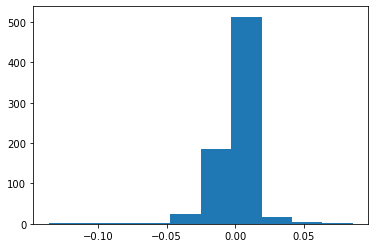

In [11]:
plt.hist(df["Return%"])

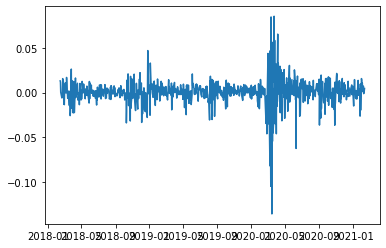

In [12]:
plt.plot(df["Return%"])

(array([  2.,   7.,   3.,  36., 195., 457.,  42.,   5.,   3.,   1.]),
 array([-0.17966628, -0.14430223, -0.10893817, -0.07357412, -0.03821006,
        -0.00284601,  0.03251804,  0.0678821 ,  0.10324615,  0.13861021,
         0.17397426]),
 <BarContainer object of 10 artists>)

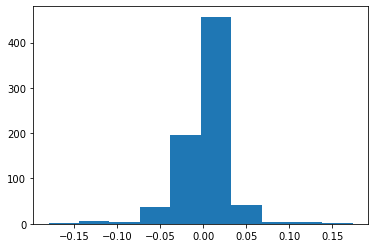

In [13]:
plt.hist(df["N5D_Return%"])

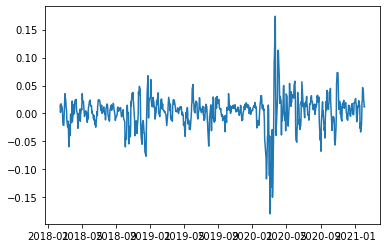

In [14]:
plt.plot(df["N5D_Return%"])

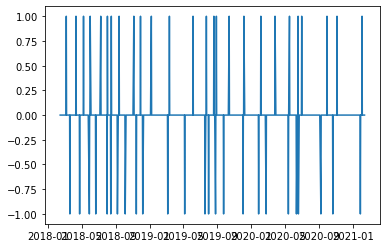

In [15]:
# Take a look at an example signal plot
plt.plot(df.SMA_Signal)

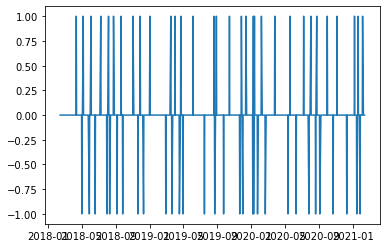

In [16]:
# Take a look at an example signal plot
plt.plot(df.MACD_Signal)

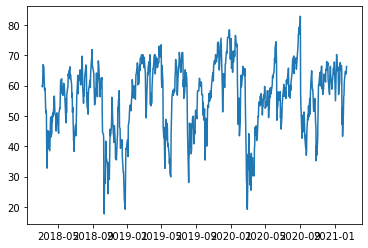

In [17]:
plt.plot(df.RSI)

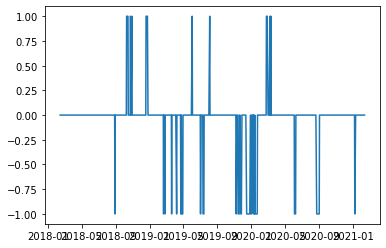

In [18]:
plt.plot(df.RSI_Signal)

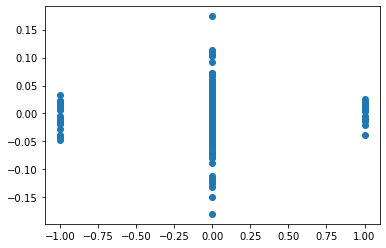

In [19]:
plt.scatter(df.SMA_Signal, df["N5D_Return%"])

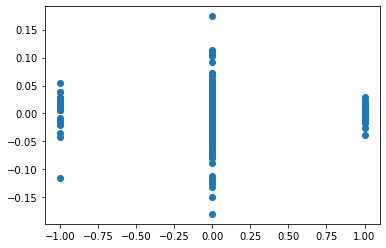

In [20]:
plt.scatter(df.MACD_Signal, df["N5D_Return%"])

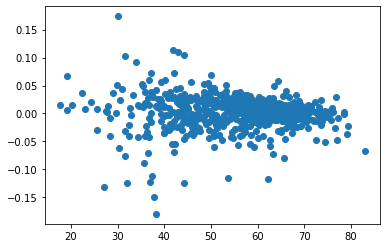

In [21]:
plt.scatter(df.RSI, df["N5D_Return%"])

## Trading Signal-Based Strategies
More info: https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html

### SMA Cross

In [4]:
class SmaCross(Strategy):
    # Define parameters of the strategy
    fast = 3
    slow = 15
    long_only = 1
    
    def init(self):
        # Compute moving averages
        self.fast_sma = self.I(SMA, self.data.Close, self.fast)
        self.slow_sma = self.I(SMA, self.data.Close, self.slow)
            
    def next(self):
        # If fast SMA crosses above slow SMA
        if crossover(self.fast_sma, self.slow_sma):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if fast SMA crosses below slow SMA
        elif crossover(self.slow_sma, self.fast_sma):
            self.position.close()
            if self.long_only == 0:
                self.sell()

### MACD

More info: https://www.investopedia.com/terms/m/macd.asp

In [5]:
class MacdSignal(Strategy): 
    # Define parameters of the strategy
    fastperiod = 12
    slowperiod = 26
    signalperiod = 9
    long_only = 1
    
    def init(self):
        # Compute MACD
        self.macd, self.macdsignal, self.macdhist = self.I(
             MACD, self.data.Close, self.fastperiod, self.slowperiod, self.signalperiod)
        
    def next(self):
        # If MACD crosses above signal line
        if crossover(self.macd, self.macdsignal):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if MACD crosses below signal line
        elif crossover(self.macdsignal, self.macd):
            self.position.close()
            if self.long_only == 0:
                self.sell()

### RSI
More info: https://www.investopedia.com/terms/r/rsi.asp

In [6]:
class RsiSignal(Strategy): 
    # Define parameters of the strategy
    timeperiod = 14
    overbought = 70
    oversold = 30
    long_only = 1
    
    def init(self):
        # Compute RSI
        self.real = self.I(RSI, self.data.Close, self.timeperiod)
        
    def next(self):
        # If RSI enters oversold territory
        if self.real <= self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If RSI enters overbought territory
        elif self.real >= self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

### Stochastic Oscillator
More info: https://www.investopedia.com/terms/s/stochasticoscillator.asp

In [7]:
class StochOsci(Strategy): 
    # Define parameters of the strategy
    fastk_period = 5
    slowk_period = 3
    slowk_matype = 0
    slowd_period = 3
    slowd_matype = 0
    overbought = 80
    oversold = 20
    long_only = 1
    
    def init(self):
        # Compute K and D lines
        self.slowk, self.slowd = self.I(STOCH, self.data.High, self.data.Low, self.data.Close, 
                                        self.fastk_period, self.slowk_period, self.slowk_matype, 
                                        self.slowd_period, self.slowd_matype)
        
    def next(self):
        # If K and D enter oversold territory
        if self.slowk <= self.oversold and self.slowd < self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If K and D enter overbought territory
        elif self.slowk >= self.overbought and self.slowd > self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

### Stochastic RSI
More info: https://www.investopedia.com/terms/s/stochrsi.asp

In [8]:
class StochRsi(Strategy): 
    # Define parameters of the strategy
    timeperiod = 14
    fastk_period = 5
    fastd_period = 3
    fastd_matype = 0
    overbought = 80
    oversold = 20
    long_only = 1
    
    def init(self):
        # Compute K and D lines
        self.fastk, self.fastd = self.I(STOCHRSI, self.data.Close, self.timeperiod,
                                        self.fastk_period, self.fastd_period, self.fastd_matype)
        
    def next(self):
        # If K and D enter oversold territory
        if self.fastk < self.oversold and self.fastd < self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If K and D enter overbought territory
        elif self.fastk > self.overbought and self.fastd > self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

## Backtesting Strategies
Additional info: https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html

In [11]:
# Specify data timeframe and strategy to test
# Get data from Yahoo
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
# S&P500 index: ^GSPC
data = yf.download("SPY", period="1y")
strategy = SmaCross

# Run backtesting
bt = Backtest(data, strategy, cash=10_000, commission=0)
stats = bt.run()

# Display stats and plot results
print(stats)
bt.plot()

[*********************100%***********************]  1 of 1 completed
Start                     2020-02-18 00:00:00
End                       2021-02-16 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                     72.2222
Equity Final [$]                      12967.3
Equity Peak [$]                       12967.3
Return [%]                             29.673
Buy & Hold Return [%]                 16.5028
Return (Ann.) [%]                      29.673
Volatility (Ann.) [%]                 23.4651
Sharpe Ratio                          1.26456
Sortino Ratio                         2.45643
Calmar Ratio                          2.95378
Max. Drawdown [%]                    -10.0458
Avg. Drawdown [%]                    -2.60921
Max. Drawdown Duration       90 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                                    8
Win Rate [%]                             87.5
Best Trade [%]                        10.4302
Worst Trade

In [ ]:
# Contains individual trade data
stats['_trades']

In [ ]:
# Contains equity/drawdown curves. DrawdownDuration is only defined at ends of DD periods.
stats['_equity_curve']

Memo: other examples: https://kernc.github.io/backtesting.py/doc/examples/Trading%20with%20Machine%20Learning.html

### Backtesting Strategy Reliability On Multiple Years

In [ ]:
##### WORKING ON THIS #####
stats["Sharpe Ratio"]